# KS SSJ

This notebook solves the Krusell-Smith (KS) model with and without investment adjustment costs using the sequence-space Jacobian method from Auclert, Bardóczy, Rognlie, Straub (2021): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models". Henceforth, ABRS (2021). The KS notebook using their toolbox written in Python can be found [here](https://github.com/shade-econ/sequence-jacobian/blob/master/notebooks/krusell_smith.ipynb).

#### Load packages

In [2]:
using Parameters
using Setfield
using Interpolations
using Plots
using Roots
using LinearAlgebra # eigen, norm
using ForwardDiff

#### Construct structs

In [3]:

@with_kw struct ModelParameters{T} # Economic Variables
    β :: T = 0.98
    γ :: T = 1.0
    δ :: T = 0.025
    α :: T = 0.11
    epsI :: T = 4.0
    Z :: T = 0.8
    ρ :: T = 0.966
    σ2 :: T = ((1.0-ρ^2)^0.5 * 0.5)^2
end 

@with_kw struct NumericalParameters # Numerical Variables
    na   :: Int = 500 # asset grid
    na_c :: Int = 100
    amin :: Float64 = 0.0 
    amax :: Float64 = 200.0 
    ny   :: Int = 7 # income grid
    tol_pol :: Float64 = 1e-10
    max_iter :: Int = 1000
    iT :: Int = 300 
end

@with_kw struct EqParameters{T} # Equilibrium Variables
    r :: T = 0.01   # interest rate - target
    w :: T = 1.0    # wage
    K :: T = m_par.α/(r + m_par.δ) # K/Y = α / (r + δ) = K 
    Y :: T = 1.0 # target
    L :: T = 1.0 # normalization
end

@with_kw struct ContainerHA{T} # T= Array{Float64,1}
    A  :: T  = zeros(n_par.na, n_par.ny) # policy function assets
    C  :: T  = zeros(n_par.na, n_par.ny) # policy function consumption
end

@with_kw struct Grids
    gridA :: Array{Float64,1} = zeros(n_par.na)
    Π :: Array{Float64,2} = zeros(n_par.ny, n_par.ny)       # transition matrix income
    gridY :: Array{Float64,1} = zeros(n_par.ny)   # income grid
end

Grids

#### Discretization routines, endogenous grid method and Young's method to construct a transition matrix for both the wealth and the income state. 

The latter is taken from Fabio Stohler's github [here](https://github.com/Fabio-Stohler/Dynamic-Macro/blob/94612a0e3cebf89bd8e90a4109e0162711cefdd1/Functions/Young.jl).   

In [13]:
function Rouwenhorst_AR1(ρ, σ2, N)

    p= (1+ρ)/2
    q= (1+ρ)/2
    
    # Construct Markov Chain recursively
    if N ==2
        tm= [p 1-p; 1-q q]
    elseif N>2
        tm= [p 1-p; 1-q q]
        for i in 2:N-1
            tm= p .* hcat( vcat(tm, zeros(1,i)), zeros(i+1,1) ) + 
            (1-p) .* hcat( zeros(i+1,1), vcat(tm, zeros(1,i)) ) +
            (1-q) .* hcat( vcat(zeros(1,i), tm), zeros(i+1,1) ) +
                q .* hcat( zeros(i+1,1), vcat(zeros(1,i), tm) )
            
            tm[2:end-1,:]= tm[2:end-1,:]./2 # divide all but the first and last row by two
        end
    else
        println("The number of grid points needs to be larger than two")
    end
    
    # Create state vector - here M is basically sqrt(iN-1)
    ψ= sqrt((σ2 / (1 - ρ^2))) * sqrt(N - 1)
    state= LinRange(-ψ, ψ, N)

    return state, tm

end # end Rouwenhorst_AR1 function


function get_Invariant_Distribution(Π::AbstractArray)
	#Π is a Stochastic Matrix
    x = [1; (I - Π'[2:end,2:end]) \ Vector(Π'[2:end,1])]
    return  x./sum(x) #normalize so that vector sums up to 1.
end


function egm_step(m_par::ModelParameters, n_par::NumericalParameters, grids::Grids, Cprime, Cl, r, rprime, w)

    # Unpack
    @unpack_ModelParameters m_par
    @unpack_NumericalParameters n_par
    @unpack_Grids grids

    # Pre-allocation
    Ci= similar(Cprime, Float64)

    EUc= Cprime.^(-γ) * Π'  # RHS Euler (expectation)
    for y in 1:ny

        # unconstrained
        Cendog= ((1+rprime) .* β .* EUc[:,y]).^(-1/γ) # inter-temporal FOC (Euler)
        Aendog= (gridA .+ Cendog .- w.*gridY[y]) ./ (1 + r) # budget constraint
        
        # constrained
        if Aendog[1] > amin            
            Cendog_c= collect(LinRange(Cl[y], Cendog[1], na_c)[1:na_c-1]) # get consumption on lower bound
            Aendog_c= (amin .+ Cendog_c .- w.*gridY[y]) ./ (1 + r)

            Cendog= append!(Cendog_c, Cendog)
            Aendog= append!(Aendog_c, Aendog)
        end

        itpC= LinearInterpolation(Aendog, Cendog, extrapolation_bc=Line())
        Ci[:,y]= itpC.(gridA)

    end

    return Ci

end

function egm(gV_conHA::ContainerHA, m_par::ModelParameters, n_par::NumericalParameters, grids::Grids, r, rprime, w)

    # Unpack
    @unpack_ContainerHA gV_conHA
    
    
    Ci= copy(C)
    difference= 1000.0
    it=1
    Cl= zeros(n_par.ny)


    # Find consumption at lower bound (constrained agents)
    Cl= r * n_par.amin .+ w .* grids.gridY

    while difference > n_par.tol_pol && it < n_par.max_iter
        Ci= egm_step(m_par, n_par, grids, C, Cl, r, rprime, w)
        # Check and update
        difference= maximum(abs.(C .- Ci))
        C= copy(Ci)
        it= it+1
    end # end while


    # Fill policy functions
    for y in 1:n_par.ny
        A[:,y]= w .* grids.gridY[y] .+ (1+r).*grids.gridA .- C[:,y]
    end

    gV_conHA= ContainerHA(A=A, C=C) 

    # println("Finished EGM in iteration = ", it, ", and diff = ", difference)

    return gV_conHA

end

function bigTransitionMatrix(A,gridA,Π,npar)
    ida                  = [searchsortedlast(gridA,a) for a in A[:]]
    ida = reshape(ida,size(A))
    ida[A .<= gridA[1]]    .= 1 
    ida[A .>= gridA[end]]  .= npar.na-1 
    
    weightright              = (A - gridA[ida]) ./ (gridA[ida.+1]-gridA[ida])
    weightleft               = 1 .- weightright
    
    mT_r = zeros(eltype(A),npar.na,npar.ny,npar.na,npar.ny) 
    for y=1:npar.ny # all current income states
        for a=1:npar.na # all current asset states
            mT_r[a,y,ida[a,y],:]   =  weightleft[a,y] * reshape(Π[y,:],1,1,1,npar.ny)
            mT_r[a,y,ida[a,y]+1,:] =  weightright[a,y] * reshape(Π[y,:],1,1,1,npar.ny)
        end
    end
    mT  = reshape(mT_r,npar.na*npar.ny, npar.na*npar.ny)
    return mT
end


bigTransitionMatrix (generic function with 1 method)

#### Function to construct the grids

In [9]:
function make_grids(m_par, n_par)
    
    lnincomeGrid, transitionMatrix= Rouwenhorst_AR1(m_par.ρ,m_par.σ2,n_par.ny);
    incomeGrid= exp.(lnincomeGrid)
    
    distY= get_Invariant_Distribution(transitionMatrix)
    # Normalize income grid to 1
    incomeGrid= incomeGrid ./ sum(incomeGrid .* distY)
    println(" Mean income = ", sum(incomeGrid .* distY) )

    gridA= n_par.amin .+ (collect(0:n_par.na-1)./n_par.na).^2 .* (n_par.amax - n_par.amin);
    grids= Grids(gridA=gridA, Π=transitionMatrix, gridY=incomeGrid);
    
    return grids

end


make_grids (generic function with 1 method)

#### Initialization

In [10]:
n_par= NumericalParameters();
m_par= ModelParameters{Float64}();
gV_conHA= ContainerHA{Array{Float64,2}}();
eq_par= EqParameters();

grids= make_grids(m_par, n_par);

 Mean income = 1.0


#### Steady state

As usual, solve for the steady state. As in the KS Python notebook, we solve for the steady state which yields $Y=1$, $r=0.01$, and asset market clearing. The first can be solved by hand by adjusting $Z$, but asset market clearing is achieved numerically. We adjust $\beta$ to achieve this. 

In [11]:
function calibrate_β(β, m_par, eq_par, grids, n_par)
    
    @set! m_par.β = β
    
    # Get guess
    Cguess= ones(n_par.na, n_par.ny) .* eq_par.r .+ grids.gridA;
    gV_conHA= ContainerHA(C=Cguess);
    
    ## HH Problem
    gV_conHA= egm(gV_conHA, m_par, n_par, grids, eq_par.r, eq_par.r, eq_par.w)

    ## Build big transition matrix
    mT= bigTransitionMatrix(gV_conHA.A, grids.gridA, grids.Π, n_par);

    ## Find invariant distribution
    vDistr= get_Invariant_Distribution(mT)
    mA_dist= reshape(vDistr, (n_par.na, n_par.ny)); 

    ## Aggregate capital stock 
    K_agg= sum(sum(mA_dist,dims=2) .* grids.gridA)

    # return distance to target
    return (K_agg / eq_par.K) - 1

end

function steady_state(m_par, eq_par, grids, n_par)

    # Get Z in line with Y=1
    @set! m_par.Z = 1/(eq_par.K^m_par.α * eq_par.L^(1-m_par.α))
    # Get corresponding wage
    @set! eq_par.w = (1-m_par.α) * m_par.Z*(eq_par.K/eq_par.L)^(m_par.α)

    # calibrate β
    β = find_zero(b -> calibrate_β(b, m_par, eq_par, grids, n_par), m_par.β)
    @set! m_par.β = β

    # Get guess
    Cguess= ones(n_par.na, n_par.ny) .* eq_par.r .+ grids.gridA;
    gV_conHA= ContainerHA(C=Cguess);
    
    ## HH Problem
    gV_conHA= egm(gV_conHA, m_par, n_par, grids, eq_par.r, eq_par.r, eq_par.w);

    ## Build big transition matrix
    mT= bigTransitionMatrix(gV_conHA.A, grids.gridA, grids.Π, n_par);


    ## Find invariant distribution
    vD= get_Invariant_Distribution(mT)
    mA_dist= reshape(vD, (n_par.na, n_par.ny)); 

    return gV_conHA, mA_dist, mT, vD, m_par, eq_par

end

steady_state (generic function with 1 method)

In [16]:
@time gV_conHA_ss, mA_dist_ss, mT_ss, vD_ss, m_par_ss, eq_par_ss= steady_state(m_par, eq_par, grids, n_par);
println(m_par_ss)
println(eq_par_ss)


  8.435412 seconds (1.65 M allocations: 7.230 GiB, 7.95% gc time)
ModelParameters{Float64}
  β: Float64 0.9819488661639063
  γ: Float64 1.0
  δ: Float64 0.025
  α: Float64 0.11
  epsI: Float64 4.0
  Z: Float64 0.8816460975214567
  ρ: Float64 0.966
  σ2: Float64 0.016711000000000004

EqParameters{Float64}
  r: Float64 0.01
  w: Float64 0.8900000000000001
  K: Float64 3.142857142857143
  Y: Float64 1.0
  L: Float64 1.0



#### Great! Now we are ready to code the fake-news algorithm in ABRS (2021) to construct the household jacobian. This jacobian "represents the aggregate response of heterogeneous agents to perturbations to their environment at different dates" (p.11).  

Hence, we write the following functions: 
- A function implementing a single backward iteration to compute the changes in policies and the distribution when perturbing an input at date $s=T-1$ (Lemma 1 and Lemma 2 in ABRS (2021))
- A function calculating the expectation vector recursion (Definition 1 or equation (23) and Lemma 3 in ABRS (2021)) 
- A function constructing the fake-news matrix as well as the jacobian (Proposition 1 in ARBS (2021))

In [18]:
function backward_iteration(gV_conHA, mT, vD, eq_par, m_par, grids, n_par; input_var="none")

    dx = 1e-4  # perturbation magnitude

    mCPol_t = zeros(n_par.na, n_par.ny, n_par.iT)
    mAPol_t = zeros(n_par.na, n_par.ny, n_par.iT)

    vK_curly = zeros(n_par.iT)
    vC_curly = zeros(n_par.iT)
    mD_curly = zeros(n_par.na * n_par.ny, n_par.iT)
    

    # Set perturbation based on `input_var`
    drx = eq_par.r + (input_var == "r" ? dx : 0)
    dwx = eq_par.w + (input_var == "w" ? dx : 0)
    m_par_shock = @set m_par.β = m_par.β + (input_var == "beta" ? dx : 0)
    
    Cl_ss = eq_par.r * n_par.amin .+ eq_par.w .* grids.gridY
    for t in 1:n_par.iT

        if t == 1
            Cl = drx * n_par.amin .+ dwx .* grids.gridY
            mCPol_t[:,:,t] = egm_step(m_par_shock, n_par, grids, gV_conHA.C, Cl, drx, eq_par.r, dwx)
            for y in 1:n_par.ny
                mAPol_t[:,y,t] = dwx .* grids.gridY[y] .+ (1 + drx) .* grids.gridA .- mCPol_t[:,y,t]
            end
        elseif t == 2
            drprimex = eq_par.r + (input_var == "r" ? dx : 0)
            mCPol_t[:,:,t] = egm_step(m_par, n_par, grids, mCPol_t[:,:,t-1], Cl_ss, eq_par.r, drprimex, eq_par.w)
            for y in 1:n_par.ny
                mAPol_t[:,y,t] = eq_par.w .* grids.gridY[y] .+ (1 + eq_par.r) .* grids.gridA .- mCPol_t[:,y,t]
            end
        else
            mCPol_t[:,:,t] = egm_step(m_par, n_par, grids, mCPol_t[:,:,t-1], Cl_ss, eq_par.r, eq_par.r, eq_par.w)
            for y in 1:n_par.ny
                mAPol_t[:,y,t] = eq_par.w .* grids.gridY[y] .+ (1 + eq_par.r) .* grids.gridA .- mCPol_t[:,y,t]
            end
        end

        mT_dx = bigTransitionMatrix(mAPol_t[:,:,t], grids.gridA, grids.Π, n_par)

        vK_curly[t] = (sum((mAPol_t[:,:,t] - gV_conHA.A)[:] .* vD)) / dx
        vC_curly[t] = (sum((mCPol_t[:,:,t] - gV_conHA.C)[:] .* vD)) / dx
        mD_curly[:,t] = ((mT_dx - mT)' * vD) / dx
    end

    return vK_curly, vC_curly, mD_curly
end

function get_Expectation_vectors(Pol_ss,mT_ss, n_par)

    mExp= zeros(n_par.na*n_par.ny, n_par.iT+1)
    mExp[:,1]= Pol_ss[:]
    for t in 2:n_par.iT+1
        mExp[:,t]= mT_ss * mExp[:,t-1]
    end
    return mExp

end

function build_Jacobian(mExp, vY_curly, mD_curly, n_par)

    mF_curly = zeros(n_par.iT,n_par.iT)
    mF_curly[1,:] = vY_curly
    mF_curly[2:end,:] .= mExp[:,1:(n_par.iT-1)]'*mD_curly


    mJacobian = copy(mF_curly)
    for t in 2:size(mF_curly)[1]
        mJacobian[2:end, t] += mJacobian[1:end-1, t-1]
    end
    
    return mJacobian, mF_curly

end

build_Jacobian (generic function with 1 method)

#### Let's implement the steps

In [19]:
## Step 1 backward iteration - we get the Jacobians for HH outputs K and C with respect to inputs r and w 
@time vK_curly_r, vC_curly_r, mD_curly_r= backward_iteration(gV_conHA_ss, mT_ss, vD_ss, eq_par_ss, m_par_ss, grids, n_par; input_var="r")
@time vK_curly_w, vC_curly_w, mD_curly_w= backward_iteration(gV_conHA_ss, mT_ss, vD_ss, eq_par_ss, m_par_ss, grids, n_par; input_var="w");

## Step 2 calculcate expectation vectors with respect to the two outputs of interest (K and C)
mExpK= get_Expectation_vectors(gV_conHA_ss.A, mT_ss, n_par);
mExpC= get_Expectation_vectors(gV_conHA_ss.C, mT_ss, n_par);

## Step 3 and 4 - build fake news matrix
J_K_r, F_K_r= build_Jacobian(mExpK, vK_curly_r, mD_curly_r, n_par);
J_K_w, F_K_w= build_Jacobian(mExpK, vK_curly_w, mD_curly_w, n_par);
J_C_r, F_C_r= build_Jacobian(mExpC, vC_curly_r, mD_curly_r, n_par);
J_C_w, F_C_w= build_Jacobian(mExpC, vC_curly_w, mD_curly_w, n_par);

  5.173455 seconds (13.12 M allocations: 56.030 GiB, 2.14% gc time, 8.05% compilation time)
  4.873367 seconds (12.68 M allocations: 56.002 GiB, 5.16% gc time)


#### With the HH Jacobians at hand, we can replicate Figure 2 from ABRS (2021)

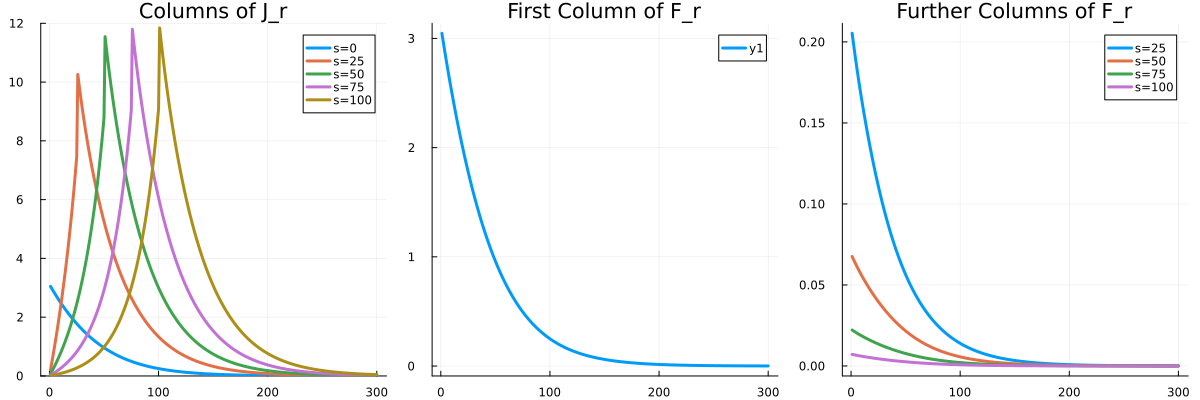

In [20]:
p1 = plot(1:n_par.iT,J_K_r[:,1 .+ [0,25,50,75,100]],linewidth = 3.0, labels = ["s=0" "s=25" "s=50"	"s=75" "s=100"], ylims = (0.0,12.0),legend = :topright,title = "Columns of J_r")
p2 = plot(1:n_par.iT,F_K_r[:,1],linewidth = 3.0,title = "First Column of F_r")
p3 = plot(1:n_par.iT,F_K_r[:,1 .+ [25,50,75,100]],linewidth = 3.0, labels = ["s=25" "s=50"	"s=75" "s=100"],title = "Further Columns of F_r")
plot(p1,p2,p3,size=(1200,400),layout = (1,3))

#### Having constructed the HH Jacobians, we now move on to general equilibrium considerations. 

The KS model can be reduced to a single assset market clearing equation (see section 2.2 in ABRS (2021)): 
$$ \mathbf{H}(\mathbf{K}, \mathbf{Z}) \equiv \mathcal{K}(r(\mathbf{K}, \mathbf{Z}), w(\mathbf{K}, \mathbf{Z})) - \mathbf{K} = 0, $$

where bold variables denote sequences and $\mathcal{K}$ maps sequences of interest rates and wages into aggregate household capital supply. $r()$ and $w()$ are functions relating the interest rate and wage to the unknown\endogenous sequence of capital $\mathbf{K}$, given the exogenous sequence of TFP $\mathbf{Z}$. Hence, market clearing is entirely a function of the sequences $\mathbf{K}$ and $\mathbf{Z}$. 

Total differentiation\Applying the implicit function theorem to this equation, we can solve for the linear impulse response of capital $d\mathbf{K}$ to a transitory technology shock $\mathbf{d\mathbf{Z}}$ around the steady state:
\begin{align*}
\left(\frac{\partial \mathcal{K}}{\partial \mathbf{r}} \frac{\partial \mathbf{r}}{\partial \mathbf{K}} + \frac{\partial \mathcal{K}}{\partial \mathbf{w}} \frac{\partial \mathbf{w}}{\partial \mathbf{K}} - I \right) d\mathbf{K} + \left(\frac{\partial \mathcal{K}}{\partial \mathbf{r}} \frac{\partial \mathbf{r}}{\partial \mathbf{K}} + \frac{\partial \mathcal{K}}{\partial \mathbf{w}} \frac{\partial \mathbf{w}}{\partial \mathbf{K}} \right) d\mathbf{Z} &= 0\\
\mathbf{H_K} d\mathbf{K} + \mathbf{H_Z} d\mathbf{Z} &= 0 \\
\mathbf{H_K} d\mathbf{K} &= -\mathbf{H_Z} d\mathbf{Z} \\
d\mathbf{K} &= - \mathbf{H_K}^{-1} \mathbf{H_Z} d\mathbf{Z}
\end{align*}

Moreover, given $d\mathbf{K}$, we can immediately solve for the impulse response of other variables $(d\mathbf{Y}, d\mathbf{r}, d\mathbf{w})$ using the chain-rule.

#### How do we obtain these partial derivatives? 

Note that the partials $\frac{\partial \mathcal{K}}{\partial \mathbf{r}}$ and $\frac{\partial \mathcal{K}}{\partial \mathbf{w}}$ are precisely our HH Jacobians! The other derivatives can be computed anlytically from the Cobb-Douglas production function! In other words, we are basically done to compute the GE responses :)

(Even though we can compute the derivatives analytically, in the following I compute them using the ForwardDiff package to get to know the syntax of this package. Mathematically, these derivatives should be of size $T \times T$, just as the household jacobians. Given the static nature of the production function, it would be a diagonal matrix with the same value and hence, from a computational implementation, to know this scalar value suffices.) 

In [30]:
function wage(K,L,Z,α)
    return (1 - α) * Z * K^α * L^(-α)
end

function interest(K,L,Z,α,δ)
    return α * Z * K^(α-1) * L^(1-α) - δ
end

fun_w(x) = wage(x[1],eq_par_ss.L,x[2], m_par_ss.α)
fun_r(x) = interest(x[1],eq_par_ss.L,x[2], m_par_ss.α, m_par_ss.δ)

drdK,drdZ = ForwardDiff.gradient(x -> fun_r(x),[eq_par_ss.K;m_par_ss.Z])
dwdK,dwdZ = ForwardDiff.gradient(x -> fun_w(x),[eq_par_ss.K;m_par_ss.Z])

println(drdK)
println(drdZ)
println(dwdK)
println(dwdZ)

-0.009911363636363635
0.03969846869213665
0.031150000000000004
1.0094753467429032


#### Now, let's chain derivatives together as written above. 

In [31]:
# Chain derivatives
H_K= J_K_r * drdK + J_K_w * dwdK - I; # uses the LinearAlgebra package for the identity matrix
H_Z= J_K_r * drdZ + J_K_w * dwdZ;
G= -inv(H_K) * H_Z;

#### Impulse responses

With the general equilibrium matrix $\mathbf{G} = - \mathbf{H_K}^{-1} \mathbf{H_Z}$ in hand, let's first constructs exogenous TFP shocks with different persistence and then capital impulse responses to replicate Figure 1 from ABRS (2021). 

In [ ]:
function compute_dZ(persistence, shock_size, shock_timing, Z_ss, n_periods)
    dZ = zeros(n_periods)
    if persistence == 0
        # One-time shock handling
        if shock_timing <= n_periods
            dZ[shock_timing] = Z_ss * (1 + shock_size)
        end
    else
        # Persistent shock with decay
        for t in shock_timing:n_periods
            dZ[t] = Z_ss * (1 + shock_size) * (persistence^(t - shock_timing))
        end
    end
    return dZ
end


# Contemporaneous shocks for different persistence
persistence= [0.2; 0.4; 0.6; 0.8; 0.9];
mZ= zeros(n_par.iT, length(persistence));
for (i,rho) in enumerate(persistence)
    mZ[:,i]= compute_dZ(rho, 0.01, 1, m_par_ss.Z, n_par.iT)
end

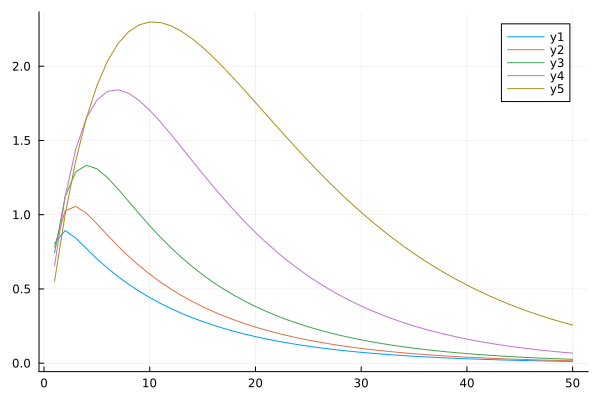

In [ ]:
plot((G * mZ)[1:50,:])

#### One-time news shock can be readily obtained from the $\mathbf{G}$ matrix:

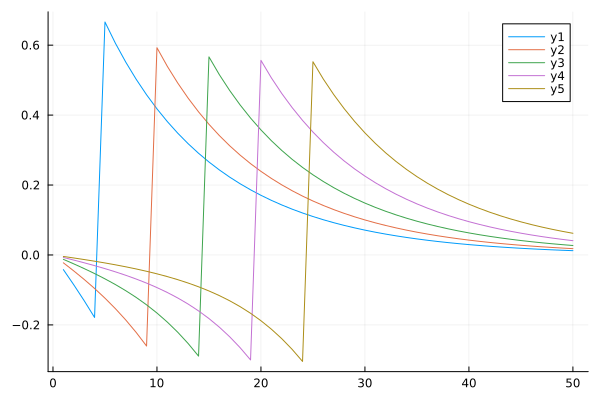

In [42]:
plot(G[1:50,[5,10,15,20,25]] * m_par_ss.Z * 1.01) # 1% one-time TFP news shock


### Introduction of investment adjustment costs

Note that the firm partial derivatives are very simple, because they can be solved analytically. These type of aggregate equations are "simple" blocks in ABRS (2021) language. Aggregate implicit relationships that cannot solved analytically are captured under "solved" blocks. One example of such a block is when we introduce capital adjustment costs. 

To account for the linear as well as the non-linear solution of these solved blocks, I use the following functions from the SSJ toolbox implementing Broyden's method. 

In [43]:

function obtain_J(f, x, y; h=1e-5)
    """Finds Jacobian f'(x) around y=f(x)"""
    nx = length(x)
    ny = length(y)
    J = Array{Float64}(undef, ny, nx)

    for i in 1:nx
        dx = h * (i .== 1:nx)
        J[:, i] = (f(x .+ dx) .- y) ./ h
    end
    
    return J
end

function broyden_update(J, dx, dy)
    """Returns Broyden update to approximate Jacobian J, given that last change in inputs to function
    was dx and led to output change of dy."""
    return J .+ ((dy - J * dx) / norm(dx)^2) * dx'
end



function broyden_solver(f, x0; y0=nothing, tol=1e-9, maxcount=100, backtrack_c=0.5, verbose=false)
    """Similar to newton_solver, but solves f(x)=0 using approximate rather than exact Newton direction,
    obtaining approximate Jacobian J=f'(x) from Broyden updating (starting from exact Newton at f'(x0)).
    
    Backtracks only if error raised by evaluation of f, since improvement criterion no longer guaranteed
    to work for any amount of backtracking if Jacobian not exact.
    """
    
    J= zeros(length(x0), length(x0))

    x, y = x0, y0
    if y === nothing
        y = f(x)
    end

    for count in 1:maxcount
        if verbose
            println("Iteration $count: x = $x, y = $y")
        end

        if maximum(abs.(y)) < tol
            return x, y
        end

        # Initialize J with Newton at the first iteration
        if count == 1
            J = obtain_J(f, x, y)
        end

        if length(x) == length(y)
            # dx = J \ -y
            dx= pinv(J)*(-y)
        elseif length(x) < length(y)
            @warn "Dimension of x ($(length(x))) is less than dimension of y ($(length(y))). Using least-squares solution."
            # dx = J \ -y
            dx= pinv(J)*(-y) #! more efficient way here?
        else
            error("Dimension of x ($(length(x))) is greater than dimension of y ($(length(y))). Cannot solve underdetermined system.")
        end

        # Backtrack up to 30 times
        for bcount in 1:30
            try
                ynew = f(x .+ dx)
                J = broyden_update(J, dx, ynew - y)
                y = ynew
                x += dx
                break
            catch e
                if verbose
                    println("Backtracking")
                end
                dx *= backtrack_c
            end
            if bcount == 30
                error("Too many backtracks, possibly due to a poor initial guess.")
            end
        end
    end
    
    error("No convergence after $maxcount iterations.")
end

broyden_solver (generic function with 1 method)

Let's introduce two functions called "labor" and "investment". The first maps capital and technology into output and wages, whereas the second captures the implicit relationship between unknowns $(K,Q)$ conditional on $(r,Z)$. 

Note: Conceptually, these functions are simplified compared to the two-asset HANK notebook by ABRS (2021); I will combine them below, even though this is not necessary, but it makes coding easier. In the two-asset notebook, ABRS (2021) have to form a combined block from these two equations because an output of the "labor" equation is an input into the "investment" equation. This is not the case here. The main point to introduce the investment adjustment costs here is to show how to handle "solved" blocks, which is in our case the "investment" equation.

In [44]:

function labor(K, Z, L, alpha, T, Kss)

    Y = zeros(T)
    w = zeros(T)

    Y[1] = Z[1] * Kss^alpha * L[1] ^ (1 - alpha)
    w[1] = (1 - alpha) * Z[1] * (Kss / L[1]) ^ alpha

    for t in 2:T
        Y[t] = Z[t] * K[t - 1] ^ alpha * L[t] ^ (1 - alpha)
        w[t] = (1 - alpha) * Z[t] * (K[t - 1] / L[t]) ^ alpha
    end
    
    return Y, w
end


function investment(Q, K, r, L, Z, delta, epsI, alpha, T, Kss, Lss, Zss, rss)
    
    inv = zeros(T)
    val = zeros(T)

    inv[1] = (K[1] / Kss - 1) / (delta * epsI) + 1 - Q[1]
    val[1] = alpha * Z[2] * (L[2] / K[1]) ^ (1 - alpha) - 
             (K[2] / K[1] - (1 - delta) + (K[2] / K[1] - 1) ^ 2 / (2 * delta * epsI)) + 
             K[2] / K[1] * Q[2] - (1 + r[2]) * Q[1]

    for t in 2:T-1
        inv[t] = (K[t] / K[t - 1] - 1) / (delta * epsI) + 1 - Q[t]
        val[t] = alpha * Z[t + 1] * (L[t + 1] / K[t]) ^ (1 - alpha) - 
                 (K[t + 1] / K[t] - (1 - delta) + (K[t + 1] / K[t] - 1) ^ 2 / (2 * delta * epsI)) + 
                 K[t + 1] / K[t] * Q[t + 1] - (1 + r[t + 1]) * Q[t]
    end

    inv[T] = (K[T] / K[T - 1] - 1) / (delta * epsI) + 1 - Q[T]
    val[T] = alpha * Zss * (Lss / K[T]) ^ (1 - alpha) - 
             (Kss / K[T] - (1 - delta) + (Kss / K[T] - 1) ^ 2 / (2 * delta * epsI)) + 
             Kss / K[T] * 1.0 - (1 + rss) * Q[T]


    
    return inv, val
end

# Note: to combine the two for the root-finding step as in the two-asset HANK notebook is not necessary. the output of the labor function is not an input to the investment function - I do it to get the other derivatives in the same go
function combine_labor_investment(r, L, Z, delta, epsI, alpha, T, Kss, Lss, Zss, rss)


    function residual(KQ, r, L, Z, delta, epsI, alpha, T, Kss, Lss, Zss, rss)
        
        K= KQ[1:T]
        Q= KQ[T+1:end]

        Y, w= labor(K, Z, L, alpha, T, Kss)
        inv, val= investment(Q, K, r, L, Z, delta, epsI, alpha, T, Kss, Lss, Zss, rss)
        
        return vcat(inv, val)

    end

    x0= vcat( ones(T).* Kss, ones(T))
    res_helper= (x -> residual(x, r, L, Z, delta, epsI, alpha, T, Kss, Lss, Zss, rss))
    x,y = broyden_solver(res_helper, x0)

    vK= x[1:n_par.iT]
    vQ= x[n_par.iT+1:end]
    vY, vw= labor(vK, Z, L, alpha, T, Kss)


    return vK, vQ, vY, vw

end

combine_labor_investment (generic function with 1 method)

#### Having investment adjustment costs changes the nature of our asset market clearing relationship and how to chain the derivatives. Compared to above, it is now easier to think about $\mathbf{r}$ as the endogenous/unknown variable instead of $\mathbf{K}$. We can think about the DAG then as follows: 

Unknown: r
Exogenous: Z

- r and Z are inputs to the production block which has outputs w,K, and Q. 
- r and w (output from production block) enter the HA block with output $\mathcal{K}$.  
- K (from the production block) and A (from HA block) enter asset market clearing. 

The asset market clearing equation can thus be written as: 
$$ \mathcal{K}(\mathbf{r}, w(\mathbf{r},\mathbf{Z})) - K(\mathbf{r}, \mathbf{Z}) = 0, $$
where $\mathcal{K}$ is the capital supply function based on the HA block and $K()$ is the capital demand function based on the production block. Similar arguments as above thus yield: 
$$ d\mathbf{r} = - \mathbf{H_r}\mathbf{H_Z} d \mathbf{Z} $$
with 
- $\mathbf{H_r} = \frac{\delta \mathcal{K}}{\partial \mathbf{r}} + \frac{\delta \mathcal{K}}{\partial \mathbf{w}} \frac{\delta \mathbf{w}}{\partial \mathbf{r}} - \frac{\delta K}{\partial \mathbf{r}} $
- $\mathbf{H_Z} = \frac{\delta \mathcal{K}}{\partial \mathbf{w}} \frac{\delta \mathbf{w}}{\partial \mathbf{Z}} - \frac{\delta K}{\partial \mathbf{Z}}$. 

Again, $\frac{\delta \mathcal{K}}{\partial \mathbf{r}}$ and $\frac{\delta \mathcal{K}}{\partial \mathbf{w}}$ are the HH Jacobians, which we already computed (the steady state with and without adjustment costs is the same). Hence, the production block derivatives remain to be calculated; now numerically. 

#### The direct, non-linear, brute-force approach to get $\frac{\delta K}{\partial \mathbf{r}}$ and $\frac{\delta K}{\partial \mathbf{Z}}$ would be to feed in perturbations $d\mathbf{r}$ and $d\mathbf{Z}$, respectively, for every time point t in our time horizon and see how the unknown capital changes in response. 
Let's do that first. Construct the jacobians directly by solving the investment equation numerically for each iteration:

In [45]:

vZss= m_par_ss.Z  .* ones(n_par.iT+1)
vLss= eq_par_ss.L .* ones(n_par.iT+1)
vrss= eq_par_ss.r .* ones(n_par.iT+1)
vKss= eq_par_ss.K .* ones(n_par.iT+1)

# I want dK_t/dZ_s -> how does K in t change, when I change Z in s? s is the column
dKdZ= zeros(n_par.iT, n_par.iT);
dQdZ= zeros(n_par.iT, n_par.iT);
dYdZ= zeros(n_par.iT, n_par.iT);
dwdZ= zeros(n_par.iT, n_par.iT);

vZ_dx= copy(vZss);
vr_dx= copy(vrss);
vK_dx= copy(vKss);

@time for i in 1:n_par.iT
    vZ_dx[i] += 1e-4;
    K,Q,Y,w= combine_labor_investment(vrss, vLss, vZ_dx, m_par_ss.δ, 4.0, 0.11, n_par.iT, eq_par_ss.K, eq_par_ss.L, m_par_ss.Z, eq_par_ss.r);
    dKdZ[:,i]= (K .- eq_par_ss.K) / 1e-4;
    dQdZ[:,i]= (Q .- 1.0) / 1e-4;
    dYdZ[:,i]= (Y .- eq_par_ss.Y) / 1e-4;
    dwdZ[:,i]= (w .- eq_par_ss.w) / 1e-4;
    vZ_dx= copy(vZss);
end


dKdr= zeros(n_par.iT, n_par.iT);
dQdr= zeros(n_par.iT, n_par.iT);
dYdr= zeros(n_par.iT, n_par.iT);
dwdr= zeros(n_par.iT, n_par.iT);


@time for i in 1:n_par.iT
    vr_dx[i] += 1e-4;
    K,Q,Y,w= combine_labor_investment(vr_dx, vLss, vZss, m_par_ss.δ, 4.0, 0.11, n_par.iT, eq_par_ss.K, eq_par_ss.L, m_par_ss.Z, eq_par_ss.r);
    dKdr[:,i]= (K .- eq_par_ss.K) / 1e-4;
    dQdr[:,i]= (Q .- 1.0) / 1e-4;
    dYdr[:,i]= (Y .- eq_par_ss.Y) / 1e-4;
    dwdr[:,i]= (w .- eq_par_ss.w) / 1e-4;
    vr_dx= copy(vrss);
end

 84.409969 seconds (3.88 M allocations: 16.396 GiB, 0.42% gc time, 1.23% compilation time)
163.785227 seconds (2.38 M allocations: 24.308 GiB, 0.21% gc time)


Phew, that took a long time. Another approach is to use the implicit function theorem again and to linearize around the steady state that solves the solved block. Indeed, one can view the solved block as nothing else than a SHADE model with inputs, outputs and targets. Hence, we can use the implicit function theorem to compte the jacobians of this block, without going through the slow, brute-force way we did above. 

Let's do this! Take the derivatives along the DAG of our solved block and use the IFT. 
The DAG here is super simple. Both K and Q enter the two targets inv (H1) and val (H2) as unknowns with r and Z as exogenous variables. All in all, the idea is the same as before. With two targets, we have to stack responses to compute the Jacobian. 

In [46]:
function jacobian_dKQ_drZ(Q, K_init, r, L, Z, delta, epsI, alpha, T, Kss, Lss, Zss, rss; epsilon=1e-4)
    # Compute inv and val at the initial values of K and r
    base_inv, base_val = investment(Q, K_init, r, L, Z, delta, epsI, alpha, T, Kss, Lss, Zss, rss)

    # Initialize matrices for partial derivatives
    inv_K = zeros(T, T)
    val_K = zeros(T, T)
    val_Q = zeros(T, T)
    inv_Q = zeros(T, T)
    inv_r = zeros(T, T)
    val_r = zeros(T, T)
    inv_Z = zeros(T, T)
    val_Z = zeros(T, T)

    # Calculate inv_K and val_K using finite differences
    for j in 1:T
        perturbed_K = copy(K_init)
        perturbed_K[j] += epsilon
        perturbed_inv, perturbed_val = investment(Q, perturbed_K, r, L, Z, delta, epsI, alpha, T, Kss, Lss, Zss, rss)
        inv_K[:, j] = (perturbed_inv - base_inv) / epsilon
        val_K[:, j] = (perturbed_val - base_val) / epsilon
    end

    # Calculate inv_Q and val_Q using finite differences
    for j in 1:T
        perturbed_Q = copy(Q)
        perturbed_Q[j] += epsilon
        perturbed_inv, perturbed_val = investment(perturbed_Q, K_init, r, L, Z, delta, epsI, alpha, T, Kss, Lss, Zss, rss)
        inv_Q[:, j] = (perturbed_inv - base_inv) / epsilon
        val_Q[:, j] = (perturbed_val - base_val) / epsilon
    end

    # Calculate inv_r and val_r using finite differences
    for j in 1:T
        perturbed_r = copy(r)
        perturbed_r[j] += epsilon
        perturbed_inv, perturbed_val = investment(Q, K_init, perturbed_r, L, Z, delta, epsI, alpha, T, Kss, Lss, Zss, rss)
        inv_r[:, j] = (perturbed_inv - base_inv) / epsilon
        val_r[:, j] = (perturbed_val - base_val) / epsilon
    end

    # Calculate inv_Z and val_Z using finite differences
    for j in 1:T
        perturbed_Z = copy(Z)
        perturbed_Z[j] += epsilon
        perturbed_inv, perturbed_val = investment(Q, K_init, r, L, perturbed_Z, delta, epsI, alpha, T, Kss, Lss, Zss, rss)
        inv_Z[:, j] = (perturbed_inv - base_inv) / epsilon
        val_Z[:, j] = (perturbed_val - base_val) / epsilon
    end

    # Stack inv and val results to form the Jacobian with respect to K, Q, and r
    target_K = vcat(inv_K, val_K)
    target_Q = vcat(inv_Q, val_Q)
    target_r = vcat(inv_r, val_r)
    target_Z = vcat(inv_Z, val_Z)
    targets= hcat(target_K, target_Q)

    # IFT with inv() function - have to align dimensions
    target_r= hcat(target_r, target_r)
    dKQ_dr = -inv(targets) * target_r # (2 * iT x 2  * iT)
    target_Z= hcat(target_Z, target_Z)
    dKQ_dZ = -inv(targets) * target_Z # (2 * iT x 2 * iT)

    # Or least squares option
    # dKQ_dr= - targets \ target_r # (2 * iT x iT)
    # dKQ_dZ= - targets \ target_Z # (2 * iT x iT)

    return dKQ_dr, dKQ_dZ
end


jacobian_dKQ_drZ (generic function with 1 method)

In [51]:
dKQ_dr_IFT, dKQ_dZ_IFT= jacobian_dKQ_drZ(ones(n_par.iT), vKss, vrss, vLss, vZss, m_par_ss.δ, m_par_ss.epsI, m_par_ss.α, n_par.iT, eq_par_ss.K, eq_par_ss.L, m_par_ss.Z, eq_par_ss.r; epsilon=1e-6)

dKdr_IFT= dKQ_dr_IFT[1:n_par.iT,1:n_par.iT]
dKdZ_IFT= dKQ_dZ_IFT[1:n_par.iT,1:n_par.iT]

println(maximum(abs.(dKdr .- dKdr_IFT)))
println(maximum(abs.(dKdZ .- dKdZ_IFT)))

0.004988626131281038
8.999990627889254e-5


What is left to do is to compute the partials including the wage from the "labor" equation. 

Recall that wage is a function of $K$, which, from the perspective of the solved block is a function of both $r$ and $Z$. Hence we use the chain rule.  

In [75]:
dwdK_a= (1 - m_par_ss.α) * m_par_ss.Z * m_par_ss.α * (eq_par_ss.K / eq_par_ss.L) ^ (m_par_ss.α - 1) * (1 / eq_par_ss.L);
dwdZ_a= (1 - m_par_ss.α) * (eq_par_ss.K / eq_par_ss.L) ^ (m_par_ss.α );

In [76]:
dwdr_a = dwdK_a * dKdr_IFT; # only indirect effect of r via K
dwdZ_a = Diagonal(ones(n_par.iT) .* dwdZ_a) + dwdK_a * dKdZ_IFT; # direct effect via Z + indirect effect of Z via K

Great, now we have all the objects we need! Let's compute the GE matrix $\mathbf{G}_r$, for the brute-force and the IFT approach. 

In [78]:
# Brute-force
H_r_adj= J_K_w * dwdr + J_K_r - dKdr
H_Z_adj= J_K_w * dwdZ - dKdZ
Gr_adj= -inv(H_r_adj) * H_Z_adj;

# IFT
H_r_adj_IFT= J_K_w * dwdr_a + J_K_r - dKdr_IFT
H_Z_adj_IFT= J_K_w * dwdZ_a - dKdZ_IFT
Gr_adj_IFT= -inv(H_r_adj_IFT) * H_Z_adj_IFT;


And let's construct impulse responses again! We are interested in the response of capital due to an exogenous TFP shock. Above, we computed the GE matrix for the response of the interest rate, however. To get the response of another output, here capital, we use the chain rule:

In [79]:
# apply chain rule to get reaction for K chain rule
GK_adj= dKdZ + dKdr * Gr_adj;
GK_adj_IFT= dKdZ_IFT + dKdr_IFT * Gr_adj_IFT;

Let's first compare the brute-force approach with the IFT approach:

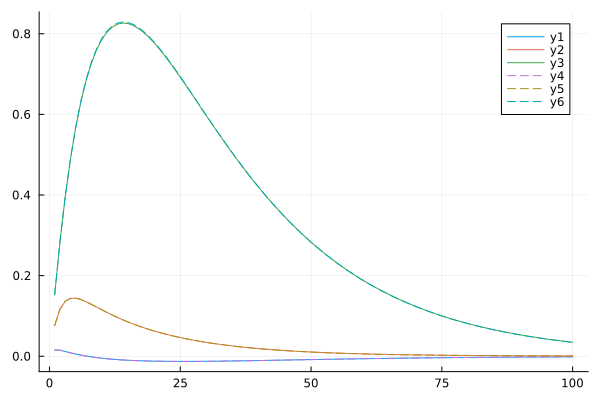

In [88]:
plot((GK_adj * mZ[:,[1,3,5]])[1:100,:])
plot!((GK_adj_IFT * mZ[:,[1,3,5]])[1:100,:], ls=:dash)

Great to see that both approaches yield the same impulse responses! 

The more interesting exercise is, of course, to compare the response with and without adjustment costs:

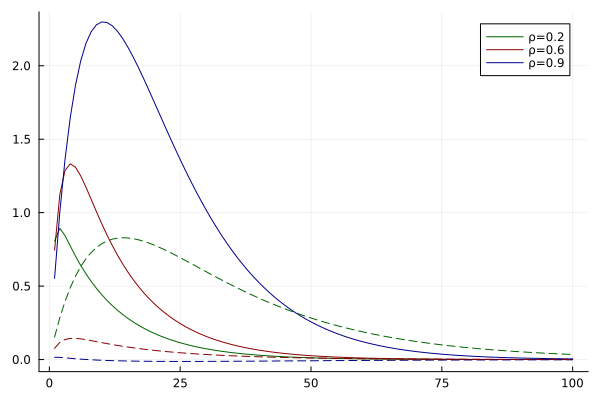

In [93]:
plot((G * mZ[:,[1,3,5]])[1:100,:],label=["ρ=0.2" "ρ=0.6" "ρ=0.9"], lc= [:darkgreen :darkred :darkblue])
plot!((GK_adj_IFT * mZ[:,[1,3,5]])[1:100,:], ls=:dash, lc= [:darkblue :darkred :darkgreen], label="")